In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch_june_analyser import Analyser
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 150
import matplotlib.pyplot as plt

/cosma/home/dp004/dc-quer1/.conda/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
an = Analyser.from_file("../../GradABM/Data/June/best_run.yaml")
an.run()

AttributeError: 'NodeStorage' object has no attribute 'ethnicity'

In [8]:
dd = an.get_gradient_cases_by_location("2020-05-01")

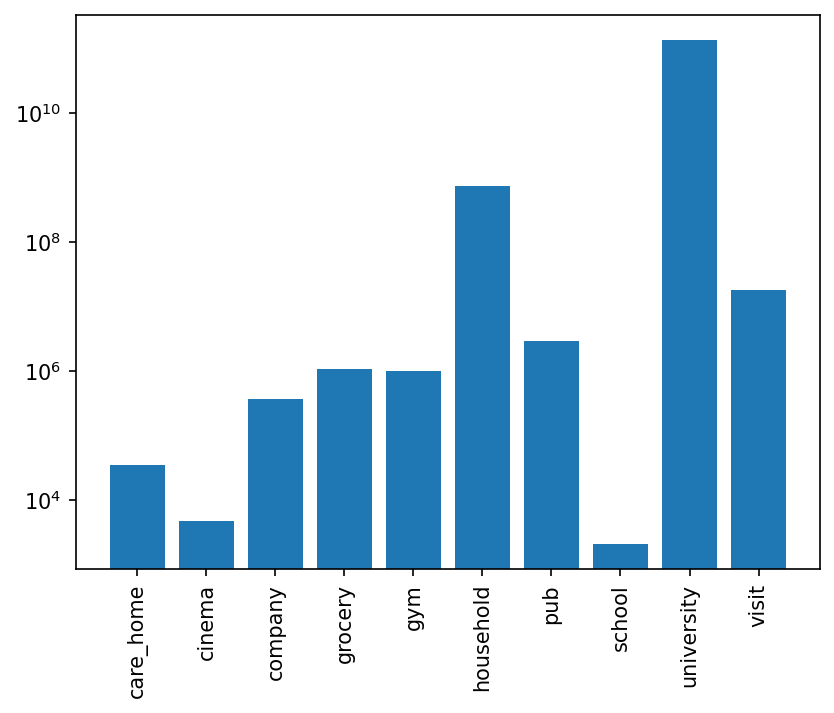

In [10]:
f, ax = plt.subplots()
ax.bar(dd.keys(), dd.values())
plt.xticks(rotation=90);
ax.set_yscale("log")

In [11]:
dd = an.get_gradient_cases_by_age_location("2020-05-01")

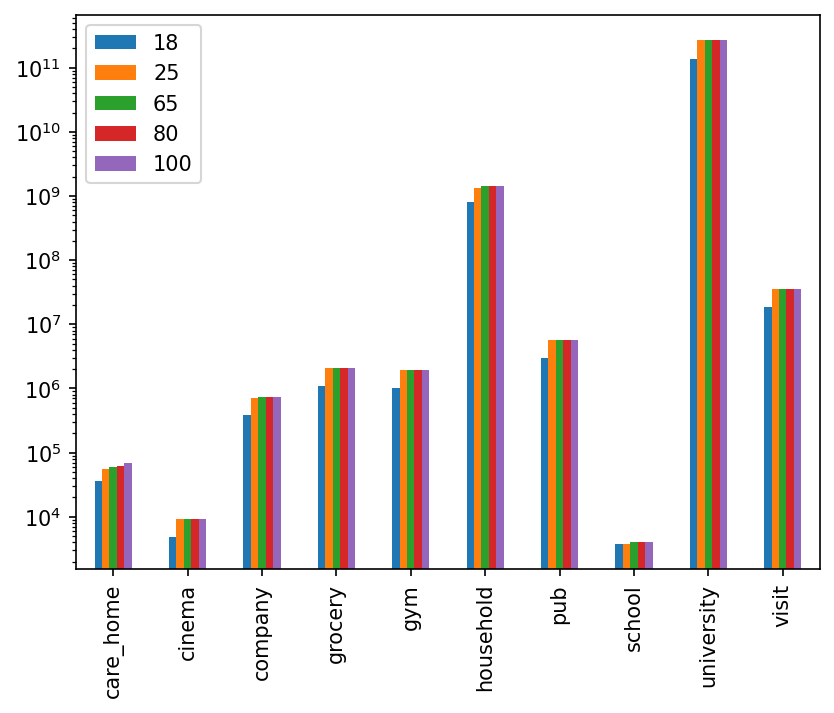

In [14]:
df = pd.DataFrame(dd)
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_yscale("log")

In [ ]:
dd = an.get_gradient_cases_by_ethnicity_location("2020-05-01")

In [ ]:
df = pd.DataFrame(dd)

In [ ]:
#for ethn in ["A", "B", "C", "D", "E"]:
#    cols = [col for col in df.columns if col.startswith(ethn)]
#    df[ethn] = df[cols].mean(1)
#    df = df.drop(columns=cols)
#df

NameError: name 'df' is not defined

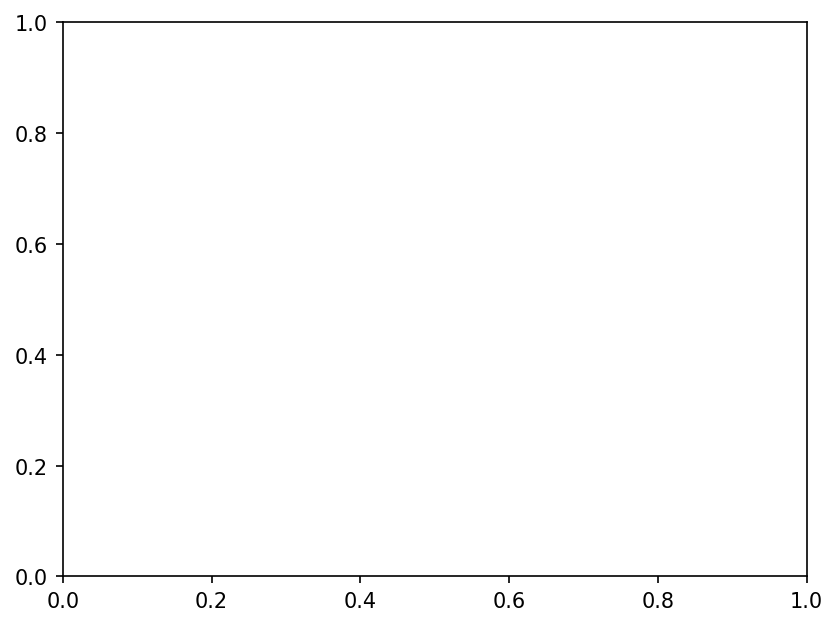

In [4]:
f, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.legend(title="ethnicity")
ax.set_yscale("log")

In [101]:
newton_step = an.get_newton_step("2022-02-03")

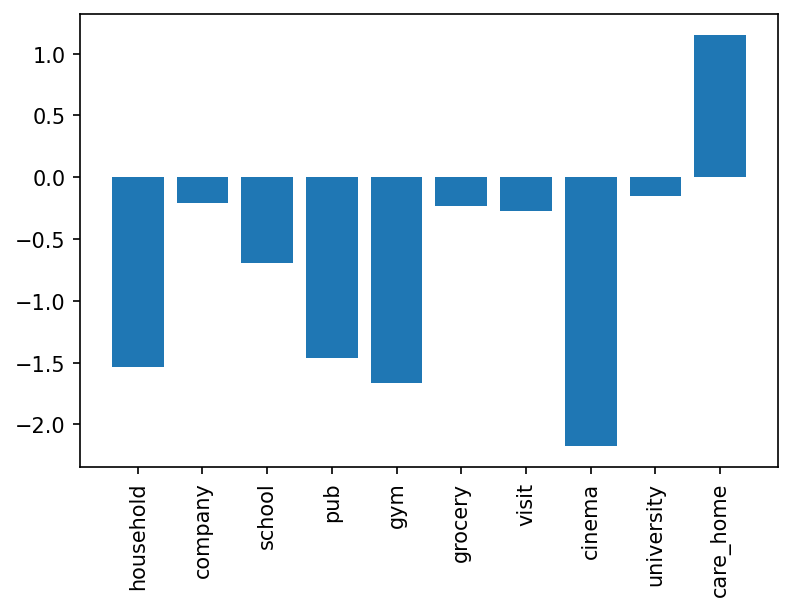

In [100]:
fig, ax = plt.subplots()
ax.bar(newton_step.keys(), newton_step.values())
plt.xticks(rotation=90);